In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

In [ ]:
# Load Dataset and split into partitions
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Create a validation set from training images
validation_images = train_images[:5000]
validation_labels = train_labels[:5000]

In [ ]:
# Analyze the stuctural properties of the training dataset
print("Shape of images", train_images.shape)
print("Shape of labels", train_labels.shape)
print("Number of labels",  train_labels[0])

# Alternatively you can use the Python len() method
print("Number of training images", len(train_images))
print("Number of training labels", len(train_labels))

# Analyze the stuctural properties of the test dataset
print("Shape of images", test_images.shape)
print("Shape of labels", test_labels.shape)
print("Number of labels",  test_labels[0])

# Alternatively you can use the Python len() method
print("Number of test images", len(test_images))
print("Number of test labels", len(test_labels))

In [17]:
# Example of training label content
print(train_labels[0])
print("Minimum value of training labels", train_labels.min())
print("Maximum value of training labels", train_labels.max())

9
Minimum value of train_label 0
Maximum value of train_label 9


In [20]:
# Content of training images before normalisation
print(train_images[0])
print("Minimum value of training images", train_images.min())
print("Maximum value of training images", train_images.max())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.00392157 0.    

In [27]:
# TODO: Test that this works on TensorFlow version 2.1+
# Normalizing trianing images through keras preprocessing layers
normalization_layer = preprocessing.Normalization()
normalization_layer.adapt(train_images)
train_images = normalization_layer(train_images)

# Normalize test images
normalization_layer.adapt(test_images)
test_images = normalization_layer(test_images)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

AttributeError: module 'tensorflow_core.keras.layers' has no attribute 'experimental'

In [15]:
# Normalise training and test images
train_images = train_images / 255.0
test_images = test_images / 255.0


In [21]:
# Content of training images after normalisation
print("Minimum value of training images", train_images.min())
print("Maximum value of training images", train_images.max())

Minimum value of training images 0.0
Maximum value of training images 1.0


In [22]:
# Label	Description
# 0	T-shirt/top
# 1	Trouser
# 2	Pullover
# 3	Dress
# 4	Coat
# 5	Sandal
# 6	Shirt
# 7	Sneaker
# 8	Bag
# 9	Ankle boot
fashion_mnist_class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fashion_mnist_class_names[train_labels[2]]

'T-shirt/top'

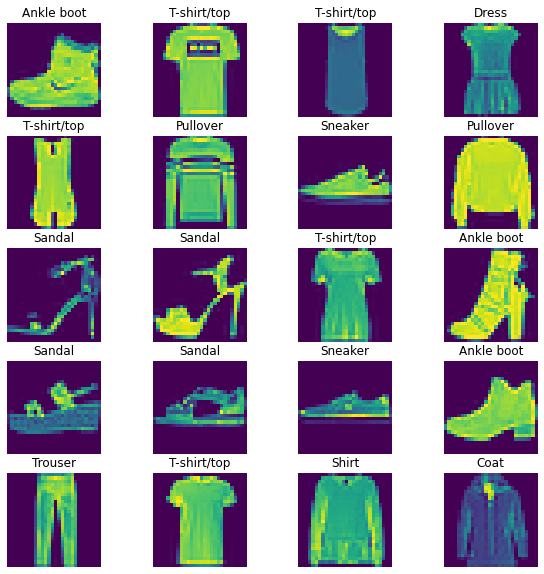

In [28]:
# Visualising data
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.axis("off")
    plt.title(fashion_mnist_class_names[train_labels[i]])
    plt.imshow(train_images[i])
plt.show()

In [11]:
# Classification MLP(Multilayer perceptron) with three hidden layers
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(500, activation=keras.activations.relu),
    keras.layers.Dense(250, activation=keras.activations.relu),
    keras.layers.Dense(100, activation=keras.activations.relu),
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 543,860
Trainable params: 543,860
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Model compilation and initialisation of optimizer
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

In [15]:
# Configure TensorBoard storage location
root_logdir = os.path.join(os.curdir, "runs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [16]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
# Train model
model.fit(train_images, train_labels, epochs=60, validation_data=(validation_images, validation_labels), callbacks=[tensorboard_cb, early_stopping_cb])

Train on 60000 samples, validate on 5000 samples
Epoch 1/60
60000/60000 [==============================] - 9s 144us/sample - loss: 0.4886 - accuracy: 0.8246 - val_loss: 0.3527 - val_accuracy: 0.8732
Epoch 2/60
60000/60000 [==============================] - 8s 129us/sample - loss: 0.3649 - accuracy: 0.8654 - val_loss: 0.3079 - val_accuracy: 0.8868
Epoch 3/60
60000/60000 [==============================] - 8s 133us/sample - loss: 0.3279 - accuracy: 0.8784 - val_loss: 0.2960 - val_accuracy: 0.8906
Epoch 4/60
60000/60000 [==============================] - 8s 132us/sample - loss: 0.3022 - accuracy: 0.8861 - val_loss: 0.2670 - val_accuracy: 0.8994
Epoch 5/60
60000/60000 [==============================] - 8s 134us/sample - loss: 0.2860 - accuracy: 0.8921 - val_loss: 0.2479 - val_accuracy: 0.9100
Epoch 6/60
60000/60000 [==============================] - 10s 159us/sample - loss: 0.2699 - accuracy: 0.8976 - val_loss: 0.2344 - val_accuracy: 0.9144
Epoch 7/60
60000/60000 [==========================

In [17]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 40us/sample - loss: 0.3596 - accuracy: 0.8907


[0.3596461825724691, 0.8907]

In [18]:
practical_test_images =  test_images[:10]
prediction_probabilites = model.predict(practical_test_images)
prediction_probabilites

array([[9.90452945e-12, 7.05926160e-12, 3.03510683e-09, 2.89017907e-11,
        1.51396361e-11, 3.62973722e-08, 1.70793268e-10, 6.79931645e-06,
        2.73775197e-13, 9.99993205e-01],
       [2.46195239e-04, 1.13196412e-08, 9.98627305e-01, 8.14729617e-08,
        1.00012787e-03, 6.17060136e-09, 1.26182946e-04, 1.92714857e-08,
        1.14798864e-08, 6.68559395e-08],
       [1.05545933e-19, 1.00000000e+00, 9.06413013e-26, 1.13806050e-16,
        1.97752208e-19, 1.04813020e-24, 1.06799301e-14, 3.55213553e-20,
        1.45966010e-24, 2.45936832e-26],
       [6.93134419e-16, 1.00000000e+00, 1.98763842e-22, 3.10907289e-12,
        8.20796896e-17, 1.53123097e-21, 7.80685239e-12, 4.27689145e-18,
        1.20801338e-21, 8.40224106e-22],
       [6.40900731e-02, 6.10230000e-09, 2.34254403e-03, 1.37179927e-06,
        6.01002066e-05, 1.94358769e-08, 9.33504879e-01, 2.14288363e-07,
        2.81555739e-08, 8.53668439e-07],
       [2.80717730e-14, 1.00000000e+00, 7.44165219e-20, 7.57839863e-13,
   

In [19]:
def derive_predicted_classes(prediction_probabilites):
    batch_prediction = []
    for vector in prediction_probabilites:
        batch_prediction.append(np.argmax(vector))
    return batch_prediction
model_prediction = derive_predicted_classes(prediction_probabilites)
model_prediction


[9, 2, 1, 1, 6, 1, 4, 6, 5, 7]

In [20]:
model_prediction = model.predict_classes(practical_test_images)
model_prediction

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=int64)

In [21]:
np.array(fashion_mnist_class_names)[model_prediction]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

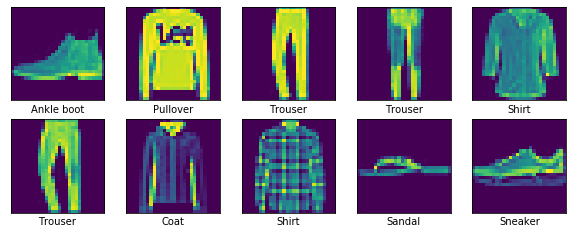

In [22]:
# Visualise the prediction result
plt.figure(figsize=(10,10))
for i in range(len(practical_test_images)):
    plt.subplot(5,5, i+1)
    plt.axis("off")
    plt.title(fashion_mnist_class_names[train_labels[i]])
    plt.grid(False)
    plt.xlabel(fashion_mnist_class_names[model_prediction[i]])
plt.show()

In [23]:
model.save("image_classification_model.h5")

In [24]:
loaded_model = keras.models.load_model("image_classification_model.h5")
predictions = loaded_model.predict_classes(practical_test_images)
print(predictions)
print(np.array(fashion_mnist_class_names)[predictions])

[9 2 1 1 6 1 4 6 5 7]
['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Trouser' 'Coat'
 'Shirt' 'Sandal' 'Sneaker']
